# Linear inverse problems and regularisation

# Overview

* Well-posedness of linear systems of equations
* The pseudo-inverse, singular value decomposition, and least-squares
* Regularisation

# Well-posedness

Given an $m\times n$ matrix $K$ and a vector $f$, solve 

$$Ku = f.$$


## Existence and uniqueness

* If the matrix is invertible ($m = n$ and full rank), we have $f = K^{-1}u$
* If $m > n$, we have an overdetermined system and we can only find a solution when $f \in \text{range}(K)$
* If $m < n$, we have an underdetermined system and can find infinitely many solutions due to the null-space of $K$

## Stability

Given $u = K^{-1}f$, $v = K^{-1}g$, we have

$$\frac{\|u - v\|}{\|u\|} \leq \|K\|\|K^{-1}\|\frac{\|f - g\|}{\|f\|}.$$

* $\|K\|$ is defined as $\max_{\|u\|} \frac{\|Ku\|}{\|u\|}$
* If $K$ is diagonalisable we have $\|K\| = \lambda_1$ (largest eigenvalue)
* $\|K\|\|K^{-1}\|$ is called the *condition number* of $K$

# The pseudo-inverse, singular value decomposition, and least-squares

## Least-squares ($m > n$)

If $m > n$, we generally do not have a solution. Instead, we can solve a least-squares problem

$$\min_u \|Ku - f\|_2^2.$$

The solution is given by 

$$u = (K^T\!K)^{-1}K^Tf$$

## Least-squares ($m < n$)

When $m < n$ we have infinitely many solutions and must choose one. For example, the one with the smalles norm.

This yields

$$u = K^T(KK^T)^{-1}f.$$

## Pseudo-inverse

In general, the minimum-norm, least-squares, solution is given by 

$$u = K^\dagger f,$$

where $K^\dagger$ is the Moore-Penrose pseudo-inverse, satisfying

* $KK^\dagger K = K$
* $K^\dagger KK^\dagger  = K^\dagger $
* $(K^\dagger K)^* = K^\dagger K$
* $(KK^\dagger)^* = KK^\dagger$

## Singular value decomposition

One way to explicitly construct the pseudo-inverse is through the *singular value decomposition*.

A matrix $K \in \mathbb{R}^{m\times n}$ can be (uniquely) decomposed as 

$$K = U \Sigma V^*,$$

where

* $U$ and $V$ are unitary (their columns are called the left and right singular vectors)
* $\Sigma$ contains the singular values on the diagonal of the upper $k \times k$ block (the rest is zero), with $k$ the rank of $K$. The singular values are positive.

The pseudo inverse is now defined as

$$K^\dagger f = \sum_{i=1}^k \frac{\langle u_i, f\rangle}{\sigma_i}v_i.$$

We can understand ill-posedness of the problem through this relation:

* The data are not informative on components for which $\langle u_i, f\rangle = 0$ or $i > k$ (so look at the corresponding $v_i's$)
* Small singular values can amplify noise if $\langle u_i, \epsilon \rangle \not= 0$

To quantify ill-posedness more precisely, we consider $\|K^\dagger f\|$:

$$\|K^\dagger f\| = \sum_{i=1}^k \frac{|\langle u_i, f\rangle|^2}{\sigma_i^2}$$

We can expect amplification of noise if $|\langle u_i, f\rangle|$ decays faster then $\sigma_i$. We call this the (discrete) Picard condition.

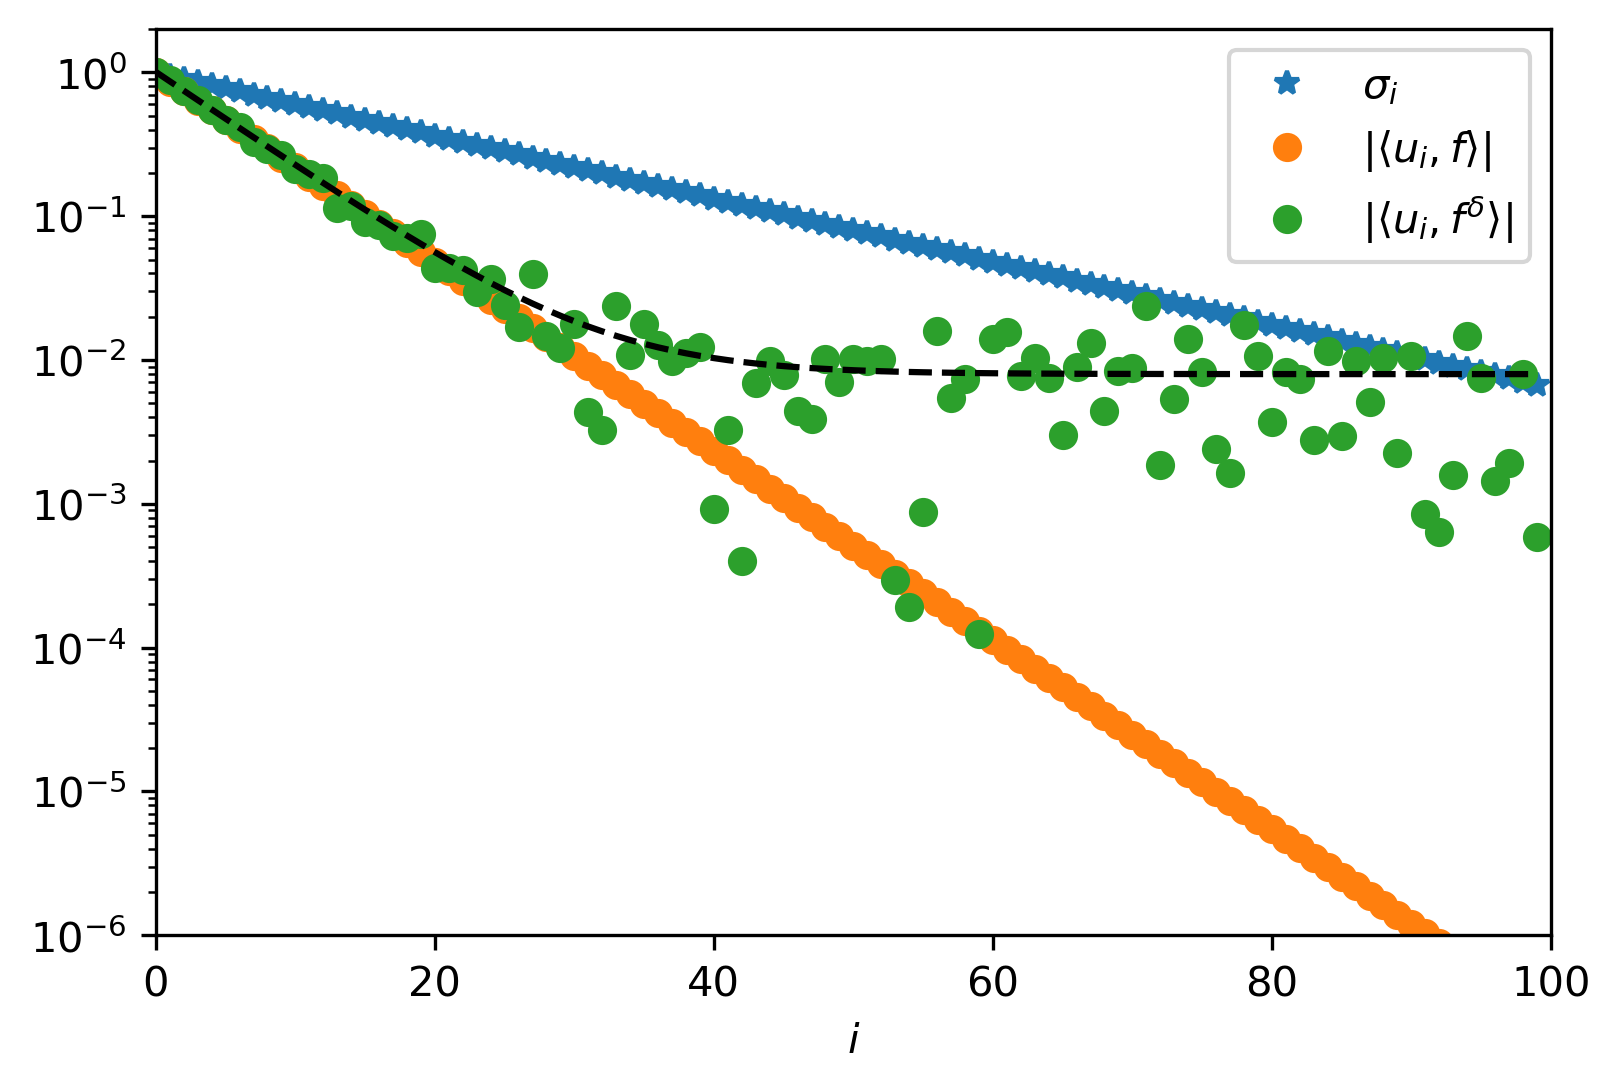

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# define forward operator
def getK(n):
    x = np.linspace(0,1,n)
    K = np.diag(np.exp(-5*x))

    return K,x

# parameters
n = 100
sigma = 1e-2
K,x = getK(n)

# define ground truth and compute data
u = np.exp(-10*x)
f = K@u

# add noise
noise = np.random.randn(n)
f_delta = f + sigma*noise

# SVD
U, s, Vh = np.linalg.svd(K, full_matrices=True)

# apply pseudo inverse
uhat = Vh.T@np.diag(1/s)@U.T@f_delta

# plot
fig, ax = plt.subplots(1,1)

ax.semilogy(s,'*',label=r'$\sigma_i$')
ax.semilogy(np.abs(U.T@f),'o',label=r'$|\langle u_i, f\rangle|$')
ax.semilogy(np.abs(U.T@f_delta),'o',label=r'$|\langle u_i, f^{\delta}\rangle|$')
ax.semilogy(np.abs(U.T@f) + np.sqrt(2/np.pi)*sigma,'k--')
ax.set_xlabel(r'$i$')
ax.set_ylim([1e-6,2])
ax.set_xlim([0,n])
ax.legend()

plt.savefig('picard.png', dpi=300)

![](picard.png)

# Regularisation


To counter ill-posedness we need to regularise the pseudo-inverse:

$$K^\dagger f = \sum_{i=1}^k \frac{\langle u_i, f\rangle}{\sigma_i}v_i$$

**Truncation:**

$$K^\dagger f = \sum_{i=1}^\color{red}{k_{\alpha}} \frac{\langle u_i, f\rangle}{\sigma_i}v_i,$$

with $k_{\alpha}$ such that $\sigma_{k_\alpha} \geq \alpha$.

**Tikhonov:**

$$K_{\color{red}{\alpha}}^\dagger f = \sum_{i=1}^k \frac{\langle u_i, f\rangle}{\sigma_i + \color{red}{\alpha}/\sigma_i}v_i,$$

which is equivalent to

$$\min_u \|Ku - f\|_2^2 + \alpha \|u\|_2^2.$$

In general, we can regularise the pseudo-inverse as

$$K_{\color{red}{\alpha}}^\dagger f = \sum_{i=1}^k \color{red}{r_{\alpha}(\sigma_i)}\langle u_i, f\rangle v_i,$$

with

* $r_{\alpha}(s) = s^{-1}$ as $\alpha \rightarrow 0$
* $r_{\alpha}(0) < \infty$ for any $\alpha > 0$
* $r_{\alpha}(s) \rightarrow 0$ as $\alpha \rightarrow \infty$

## Bias-variance trade-off

Given noise data $f^\delta = f + \epsilon$, we can split the error

$$K_{{\alpha}}^\dagger f^\delta - K^\dagger f = (K_{{\alpha}}^\dagger - K^\dagger) f + K_{{\alpha}}^\dagger e.$$

so

$$\|\widehat{u} - \widehat{u}^{\alpha, \delta}\|_2 \leq \|(K_{{\alpha}}^\dagger - K^\dagger) f \|_2 + \|K_{{\alpha}}^\dagger e\|_2.$$


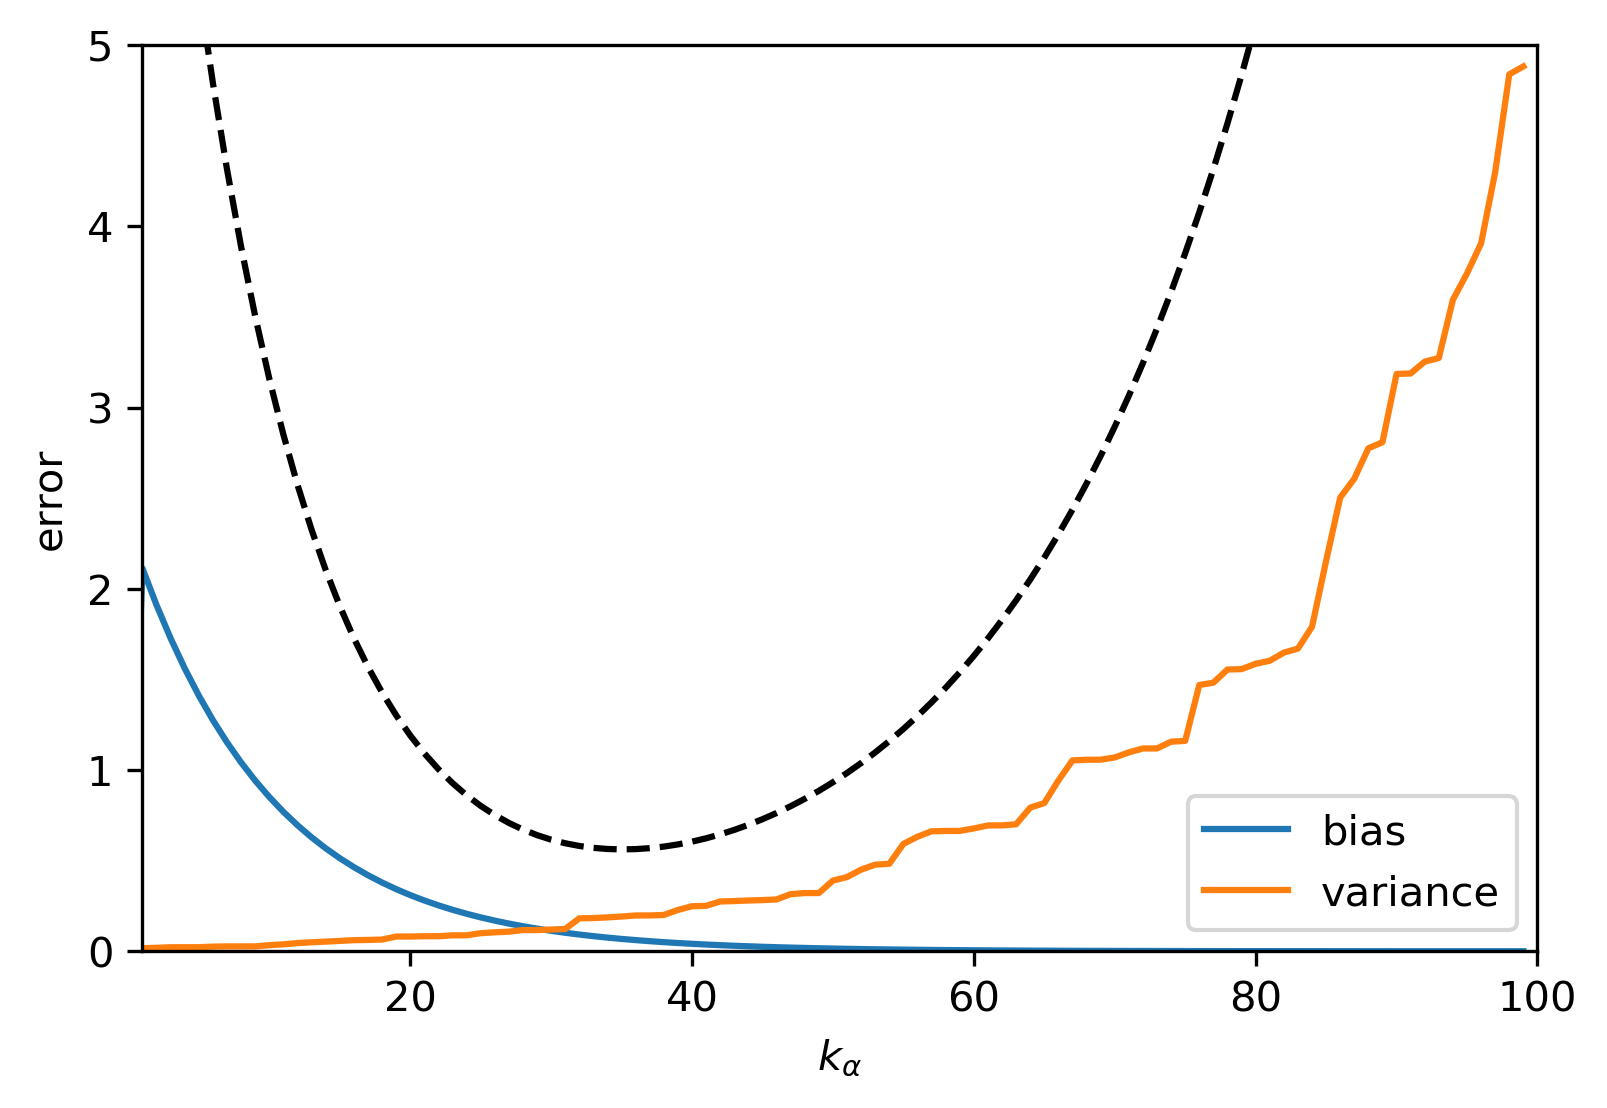

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# define forward operator
def getK(n):
    x = np.linspace(0,1,n)
    K = np.diag(np.exp(-5*x))

    return K,x

# parameters
n = 100
sigma = 1e-2
K,x = getK(n)

# define ground truth and compute data
u = np.exp(-10*x)
f = K@u

# add noise
noise = np.random.randn(n)
f_delta = f + sigma*noise

# SVD
U, s, Vh = np.linalg.svd(K, full_matrices=True)

# error, bias and variance for TSVD
error = np.zeros(n)
bias = np.zeros(n)
variance = np.zeros(n)

for k in range(1,n):
  uk = Vh[:k,:].T@np.diag(1/s[:k])@U[:,:k].T@f
  uk_delta = Vh[:k,:].T@np.diag(1/s[:k])@U[:,:k].T@f_delta

  error[k] = np.linalg.norm(u - uk_delta)
  bias[k] = np.linalg.norm(u - uk)
  variance[k] = np.linalg.norm(uk - uk_delta)

# plot
k = np.linspace(0,n-1,n)

fig, ax = plt.subplots(1,1)

ax.plot(k,bias,label='bias')
ax.plot(k,variance,label='variance')
ax.plot(k,np.exp(5*k/(n-1))*sigma*np.sqrt(k+1) + np.exp(-10*(k+1)/(n-1))*np.sqrt(n-k-1),'k--')

ax.set_xlabel(r'$k_\alpha$')
ax.set_ylabel(r'error')
ax.set_xlim([1,n])
ax.set_ylim([0,5])
ax.legend()

plt.savefig('biasvariance.png',dpi=300)

![](biasvariance.png)

# Exercise

See https://tristanvanleeuwen.github.io/IP_and_Im_Lectures/discrete_ip_regularization.html#gravity-surveying